# Importing Libraries for Text Analysis and Modeling

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn import metrics
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from sklearn.model_selection import GridSearchCV
import kagglehub
import os
import shutil 
import warnings

# Kaggle Dataset Download and Local Storage

In [ ]:
path = kagglehub.dataset_download("PATH") #force=True to re-download if needed

print("Path to downloaded dataset:", path)

version_folder = os.path.basename(path)

source_path = os.path.join(os.path.dirname(path), version_folder)
destination_path = r"\archive"

try:
    os.makedirs(destination_path, exist_ok=True)

    files = os.listdir(source_path)

    for file in files:
        source_file_path = os.path.join(source_path, file)
        destination_file_path = os.path.join(destination_path, file)

        shutil.move(source_file_path, destination_file_path)

    print(f"Contents of '{source_path}' moved to '{destination_path}' successfully.")

except FileNotFoundError:
    print(f"Error: Source directory '{source_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# SQLite Data Retrieval and DataFrame Creation

In [3]:
connection_sqlobject = sqlite3.connect('archive/database.sqlite') 
data = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)
print("Number of data points in our data", data.shape[0])
print("Number of features in our data", data.shape[1])
data.head()

Number of data points in our data 568454
Number of features in our data 10


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Dataset Summary Before Data Cleaning

In [4]:
# Display dataset information before removing duplicates
print(f"The shape of the dataset: {data.shape}")
print(f"The average score: {data['Score'].mean():.2f}")
print("\nSentiment Distribution Before Removing Duplicates:\n")
print(data["Score"].value_counts().to_string())  # Prevents truncated output

The shape of the dataset: (568454, 10)
The average score: 4.18

Sentiment Distribution Before Removing Duplicates:

Score
5    363122
4     80655
1     52268
3     42640
2     29769


In [5]:
#Breif description about the dataset
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [6]:
# Sort data by Time in ascending order (oldest reviews first)
sorted_data = data.sort_values(by='Time', ascending=True, kind='quicksort', na_position='last')

# Display the first few rows
sorted_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


## Duplicate and Invalid Row Removal

In [7]:
# Removing duplicate entries based on unique identifiers
filtered_data = sorted_data.drop_duplicates(subset=["UserId", "ProfileName", "Time", "Text"], keep="first")

# Filtering out invalid rows where HelpfulnessNumerator > HelpfulnessDenominator
final_data = filtered_data[filtered_data["HelpfulnessNumerator"] <= filtered_data["HelpfulnessDenominator"]]

# Display the new dataset shape
print(f"The shape of the dataset after removing duplicate and invalid helpfulness rows: {final_data.shape}")

# Printing how many rows were removed
rows_removed = sorted_data.shape[0] - final_data.shape[0]
print(f"Total rows removed: {rows_removed}")


The shape of the dataset after removing duplicate and invalid helpfulness rows: (393931, 10)
Total rows removed: 174523


In [8]:
# Display dataset information after deduplication
print(f"✅ The shape of the dataset after deduplication: {final_data.shape}")
print(f"📊 The mean score after deduplication: {final_data['Score'].mean():.2f}")

# Display sentiment distribution
print("\n📌 Distribution of Sentiments after deduplication:")
print(final_data["Score"].value_counts())

# Percentage of data retained
retained_percentage = (len(final_data) / len(data)) * 100
removed_percentage = 100 - retained_percentage

print("\n📈 Data Retention Analysis:")
print(f"🟢 Percentage of original data retained: {retained_percentage:.2f}%")
print(f"🔴 Percentage of redundant data removed: {removed_percentage:.2f}%")

# Free up memory by deleting unnecessary variables
del filtered_data, data, sorted_data

# Display first 5 rows of the cleaned dataset
print("\n📌 First 5 rows of the cleaned dataset after preprocessing:")
final_data.head()


✅ The shape of the dataset after deduplication: (393931, 10)
📊 The mean score after deduplication: 4.18

📌 Distribution of Sentiments after deduplication:
Score
5    250957
4     56094
1     36306
3     29770
2     20804
Name: count, dtype: int64

📈 Data Retention Analysis:
🟢 Percentage of original data retained: 69.30%
🔴 Percentage of redundant data removed: 30.70%

📌 First 5 rows of the cleaned dataset after preprocessing:


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


## Sentiment Labeling and Usefulness Feature Engineering 

In [9]:
#Give reviews with Score >= 4 a 'Positive' tag, reviews with a score <= 2 a 'Negative' tag and score with 3 'Neutral' tag
conditions = [final_data['Score'] >= 4, final_data['Score'] == 3, final_data['Score'] <= 2]

sentiments = ['Positive', 'Neutral', 'Negative']
final_data['Sentiment_Labels'] = np.select(conditions, sentiments, default='Neutral')

class_labels = [2,1,0]
final_data['Class_Labels'] = np.select(conditions, class_labels, default=1)

final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Labels,Class_Labels
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,Positive,2
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,Positive,2
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Positive,2
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",Positive,2
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,Positive,2


In [10]:
# Creating a Usefulness column which tells the percentage of users who found a review helpful

final_data['Usefulness'] = np.where(final_data['HelpfulnessDenominator'] > 0, 
                                    final_data['HelpfulnessNumerator'] / final_data['HelpfulnessDenominator'], 
                                    np.nan)

# Categorize usefulness in a vectorized manner
final_data['Usefulness'] = pd.cut(final_data['Usefulness'], 
                                  bins=[-np.inf, 0.25, 0.75, np.inf], 
                                  labels=["<25%", "25-75%", ">75%"])

# Calculate word count using pandas' str.split().str.len() (faster than looping)
final_data['Length'] = final_data['Text'].str.split().str.len()

# Display first few rows
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Labels,Class_Labels,Usefulness,Length
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,Positive,2,NaN,74
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,Positive,2,>75%,78
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Positive,2,NaN,29
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",Positive,2,25-75%,36
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,Positive,2,NaN,43


# Exploratory Data Analysis: Insights from Cleaned and Engineered Data

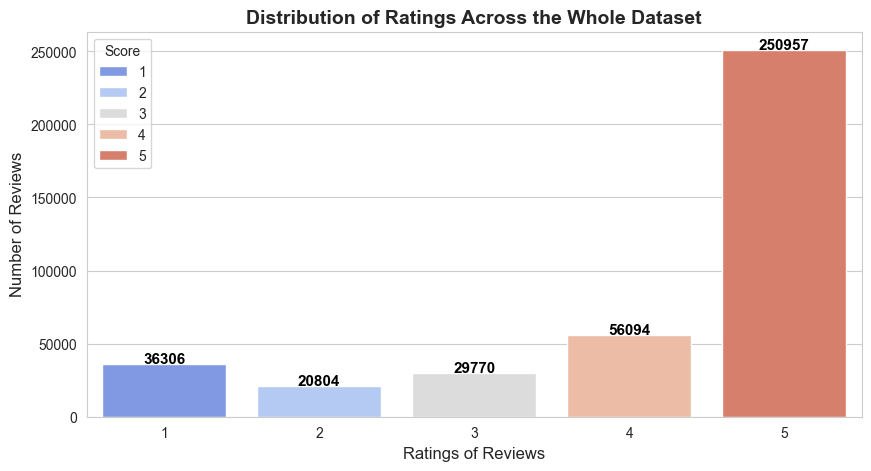

In [11]:
sns.set_style("whitegrid")
colors = sns.color_palette("coolwarm", n_colors=5)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Score', data=final_data, hue='Score' ,palette=colors, order=sorted(final_data['Score'].unique()))
plt.title("Distribution of Ratings Across the Whole Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Ratings of Reviews", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
for p in ax.patches:
    value = int(p.get_height()) 
    if value > 0:
        ax.annotate(f'{value}', 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 500), 
                    ha='center', fontsize=11, fontweight='bold', color='black')
plt.show()

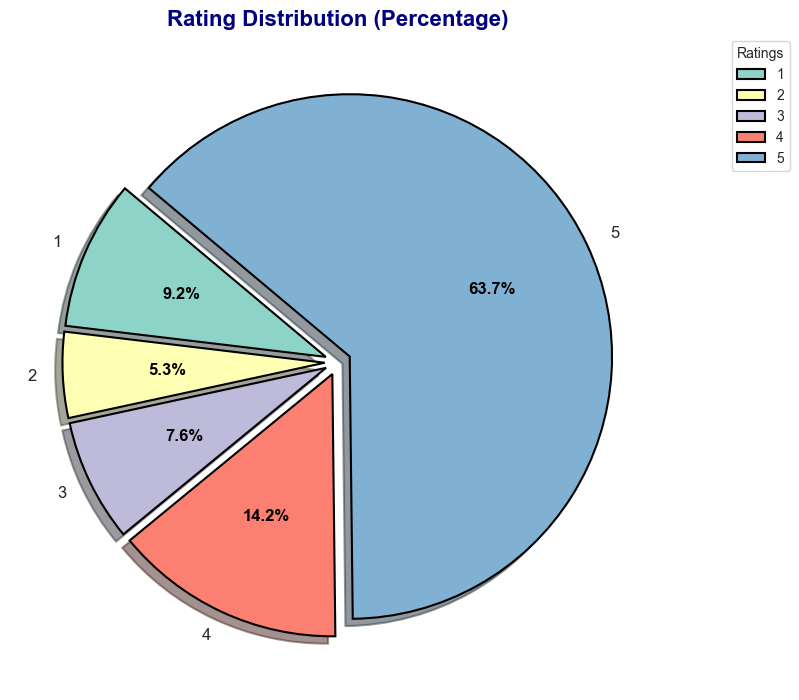

In [15]:
from io import BytesIO

# Create figure
fig = plt.figure(figsize=(8, 8))
colors = plt.get_cmap('Set3').colors  # Better color palette
wp = {'linewidth': 1.5, "edgecolor": 'black'}

# Value counts and explode settings
tags = final_data['Score'].value_counts().sort_index() / final_data.shape[0]
labels = tags.index.astype(str)
explode = [0.05] * len(tags)  # Slight explode for all slices

# Pie chart
patches, texts, autotexts = plt.pie(
    tags,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    shadow=True,
    explode=explode,
    wedgeprops=wp,
    textprops={'fontsize': 12}
)

# Formatting % text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# Title
plt.title('Rating Distribution (Percentage)', fontsize=16, fontweight='bold', color='navy')

# Add legend
plt.legend(labels, title="Ratings", loc="upper right", bbox_to_anchor=(1.2, 1))

# Save to buffer
graph = BytesIO()
plt.tight_layout()
fig.savefig(graph, format="png")

# To display in notebook (optional)
plt.show()

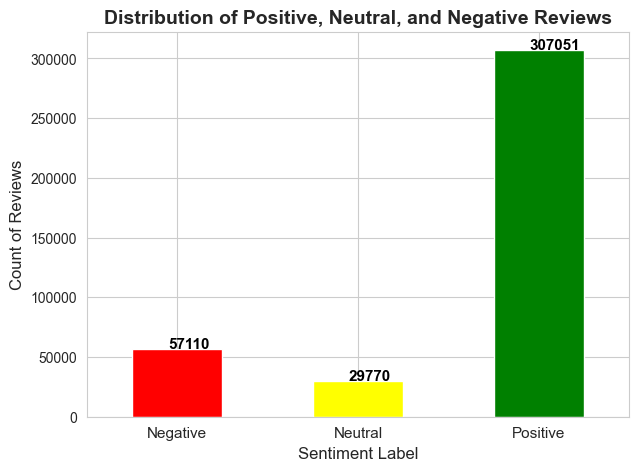

In [14]:
color_map = {0: 'red', 1: 'yellow', 2: 'green'}

plt.figure(figsize=(7, 5))

# Get value counts sorted by index (0 -> Negative, 1 -> Neutral, 2 -> Positive)
value_counts = final_data["Class_Labels"].value_counts().sort_index()

# Apply the correct colors based on index values
ax = value_counts.plot(kind='bar', color=[color_map[i] for i in value_counts.index])

plt.title('Distribution of Positive, Neutral, and Negative Reviews', fontsize=14, fontweight='bold')
plt.xlabel("Sentiment Label", fontsize=12)
plt.ylabel("Count of Reviews", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0, fontsize=11)

# Add labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.2, p.get_height() + 500), 
                fontsize=11, fontweight='bold', color='black')

plt.show()


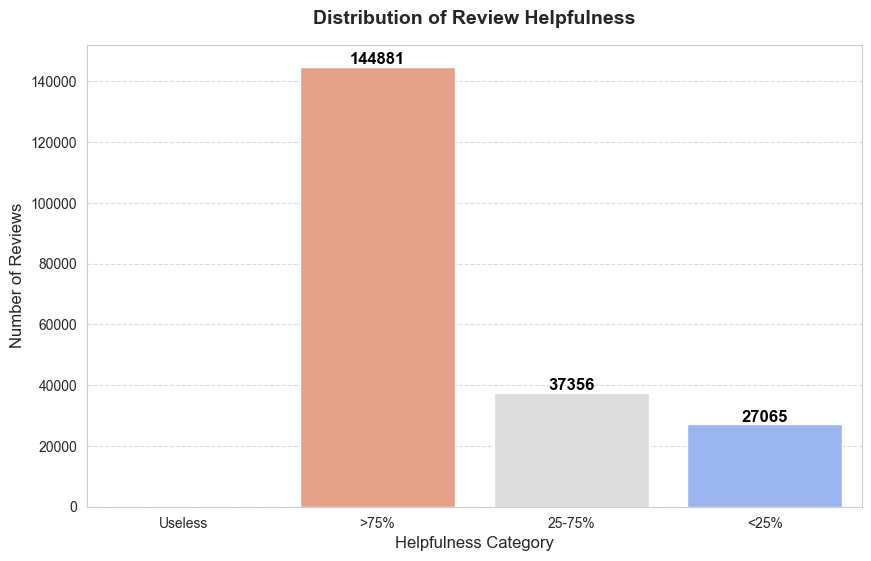

Usefulness
>75%      144881
25-75%     37356
<25%       27065
Name: count, dtype: int64

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x='Usefulness', 
    data=final_data, 
    hue='Usefulness',
    order=['Useless', '>75%', '25-75%', '<25%'], 
    legend=False,
    palette='coolwarm'
)
plt.title('Distribution of Review Helpfulness', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Helpfulness Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
final_data['Usefulness'].value_counts()

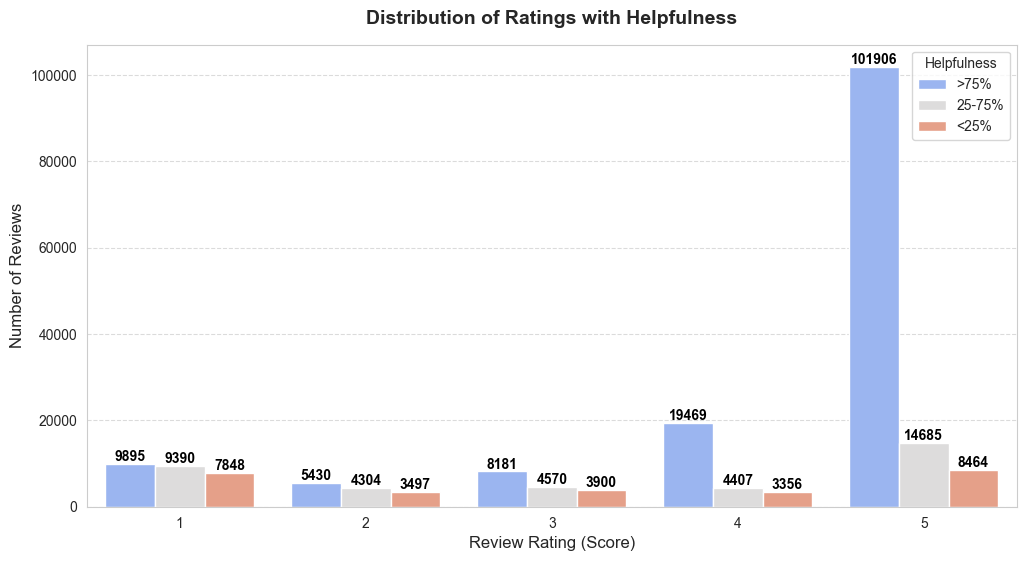

In [17]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='Score', 
    data=final_data, 
    hue='Usefulness', 
    hue_order=['>75%', '25-75%', '<25%'], 
    order=[1, 2, 3, 4, 5], 
    palette='coolwarm'
)
plt.title('Distribution of Ratings with Helpfulness', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Review Rating (Score)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Helpfulness', fontsize=10)
plt.show()


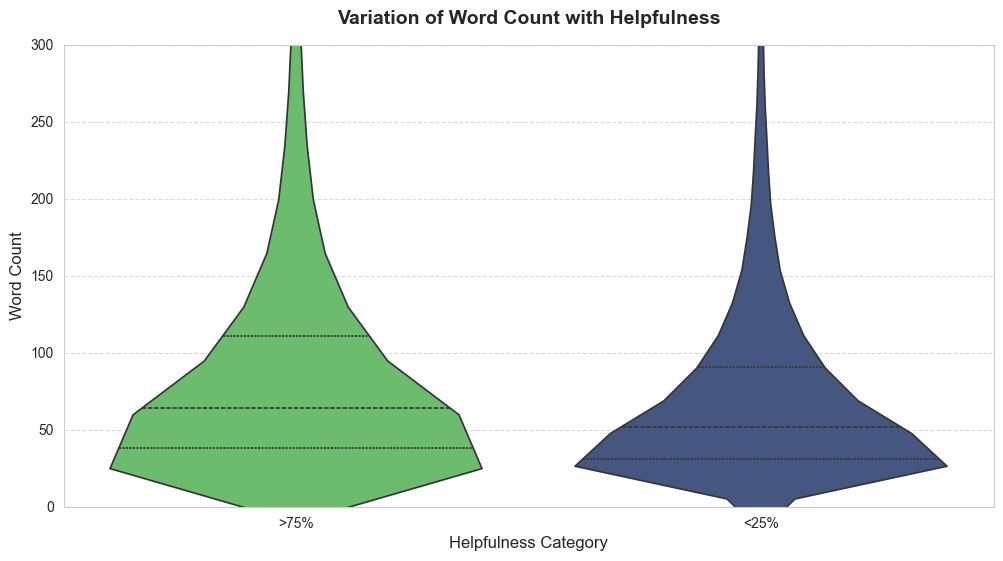

In [19]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='Usefulness', 
    y='Length', 
    data=final_data, 
    hue='Usefulness', 
    order=['>75%', '<25%'], 
    palette='viridis', 
    inner='quartile',
    legend=False
)
plt.ylim(0, 300)
plt.xlabel('Helpfulness Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title('Variation of Word Count with Helpfulness', fontsize=14, fontweight='bold', pad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Text Preprocessing Pipeline: Lemmatization vs. Stemming 

In [20]:
# Download necessary NLTK resources automatically
print("Downloading required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to handle contractions better
def expand_contractions(text):
    # Dictionary of contractions and their expansions
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

# Simple fallback tokenization function if NLTK tokenizer fails
def simple_tokenize(text):
    # Split on whitespace and remove empty strings
    return [token for token in text.split() if token]

# Improved preprocessing function with lemmatization
def preprocess_text(text):
    # Handle missing values
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r"http\S+", " ", text)
    
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Expand contractions
    text = expand_contractions(text)
    
    # Remove digits and words containing digits
    text = re.sub(r'\w*\d\w*', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation (but retain spaces)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize - with fallback if NLTK tokenizer fails
    try:
        tokens = word_tokenize(text)
    except LookupError:
        tokens = simple_tokenize(text)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                      if word not in stop_words and len(word) > 1]
    
    # Join back to text
    return ' '.join(cleaned_tokens).strip()

# For comparison - original stemming approach
def preprocess_text_with_stemming(text):
    # Initialize stemmer
    stemmer = nltk.stem.SnowballStemmer('english')
    
    # Convert to string and handle missing values
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r"http\S+", " ", text)
    
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Expand contractions (original approach)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # Remove words with numbers
    text = re.sub(r'\w*\d\w*', ' ', text)
    
    # Remove punctuation & special chars
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenization, stopword removal, and stemming in one step
    cleaned_text = ' '.join(stemmer.stem(word.lower()) for word in text.split() 
                           if word.lower() not in stop_words)
    
    return cleaned_text.strip()
    
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

preprocessed_reviews = []
stemmed_reviews = []
for sentence in final_data['Text'].astype(str).values:
    preprocessed_reviews.append(preprocess_text(sentence).strip())
    stemmed_reviews.append(preprocess_text_with_stemming(sentence).strip())

# Store preprocessed reviews in dataset
final_data['StemmedReviews'] = stemmed_reviews
final_data['PreprocessedReviews'] = preprocessed_reviews

# Display original vs cleaned text
final_data[['Text','PreprocessedReviews' ,'StemmedReviews']]


[nltk_data] Downloading package punkt to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rishi
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,PreprocessedReviews,StemmedReviews
150523,this witty little book makes my son laugh at l...,witty little book make son laugh loud recite c...,witti littl book make son laugh loud recit car...
150500,I can remember seeing the show when it aired o...,remember seeing show aired television year ago...,rememb see show air televis year ago child sis...
451855,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,beetlejuic well written movi everyth excel act...
230284,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,twist rumplestiskin captur film star michael k...
451854,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,beetlejuic excel funni movi keaton hilari wack...
...,...,...,...
362336,"Culd not eat it, but the other flavor I ordere...",culd eat flavor ordered fine sure ok one,culd eat flavor order fine sure ok one
9,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...,healthi dog food good digest also good small p...
75881,My dogs love them but they are loaded with jun...,dog love loaded junk come another country went...,dog love load junk come anoth countri went tra...
205937,I got these to give out in a goodie bag for th...,got give goodie bag holiday couple extra cours...,got give goodi bag holiday coupl extra cours a...


# Storing and Retrieving Cleaned Review Data for Model Training

In [ ]:
#Saving the preprocessed data a new csv file
useful_columns = ['Text', 'Score', 'Sentiment_Labels', 'Class_Labels', 'StemmedReviews','PreprocessedReviews']
filtered_data = final_data[useful_columns]
filtered_data.to_csv('archive/useful_sentiment_data.csv', index=False)

In [3]:
#loading the processed reviews for model prepration
refined_data=pd.read_csv("archive/useful_sentiment_data.csv")
refined_data

,Text,Score,Sentiment_Labels,Class_Labels,StemmedReviews,PreprocessedReviews
0,this witty little book makes my son laugh at l...,5,Positive,2,witti littl book make son laugh loud recit car...,witty little book make son laugh loud recite c...
1,I can remember seeing the show when it aired o...,5,Positive,2,rememb see show air televis year ago child sis...,remember seeing show aired television year ago...
2,Beetlejuice is a well written movie ..... ever...,5,Positive,2,beetlejuic well written movi everyth excel act...,beetlejuice well written movie everything exce...
3,"A twist of rumplestiskin captured on film, sta...",5,Positive,2,twist rumplestiskin captur film star michael k...,twist rumplestiskin captured film starring mic...
4,Beetlejuice is an excellent and funny movie. K...,5,Positive,2,beetlejuic excel funni movi keaton hilari wack...,beetlejuice excellent funny movie keaton hilar...
...,...,...,...,...,...,...
393917,"Culd not eat it, but the other flavor I ordere...",1,Negative,0,culd eat flavor order fine sure ok one,culd eat flavor ordered fine sure ok one
393918,This is a very healthy dog food. Good for thei...,5,Positive,2,healthi dog food good digest also good small p...,healthy dog food good digestion also good smal...
393919,My dogs love them but they are loaded with jun...,1,Negative,0,dog love load junk come anoth countri went tra...,dog love loaded junk come another country went...
393920,I got these to give out in a goodie bag for th...,5,Positive,2,got give goodi bag holiday coupl extra cours a...,got give goodie bag holiday couple extra cours...


In [4]:
refined_data.columns

Index(['Text', 'Score', 'Sentiment_Labels', 'Class_Labels', 'StemmedReviews',
       'PreprocessedReviews'],
      dtype='object')

In [5]:
refined_data[['Text','StemmedReviews','PreprocessedReviews']]

,Text,StemmedReviews,PreprocessedReviews
0,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,witty little book make son laugh loud recite c...
1,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,remember seeing show aired television year ago...
2,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,beetlejuice well written movie everything exce...
3,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,twist rumplestiskin captured film starring mic...
4,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,beetlejuice excellent funny movie keaton hilar...
...,...,...,...
393917,"Culd not eat it, but the other flavor I ordere...",culd eat flavor order fine sure ok one,culd eat flavor ordered fine sure ok one
393918,This is a very healthy dog food. Good for thei...,healthi dog food good digest also good small p...,healthy dog food good digestion also good smal...
393919,My dogs love them but they are loaded with jun...,dog love load junk come anoth countri went tra...,dog love loaded junk come another country went...
393920,I got these to give out in a goodie bag for th...,got give goodi bag holiday coupl extra cours a...,got give goodie bag holiday couple extra cours...


In [6]:
refined_data.isnull().sum()

Text                   0
Score                  0
Sentiment_Labels       0
Class_Labels           0
StemmedReviews         0
PreprocessedReviews    0
dtype: int64

In [25]:
refined_data.dropna(subset=['StemmedReviews','PreprocessedReviews'], inplace=True)
refined_data = refined_data[
    (refined_data['StemmedReviews'].str.strip() != '') &
    (refined_data['PreprocessedReviews'].str.strip() != '')
]
refined_data.to_csv('archive/useful_sentiment_data.csv', index=False)
refined_data

,Text,Score,Sentiment_Labels,Class_Labels,StemmedReviews,PreprocessedReviews
0,this witty little book makes my son laugh at l...,5,Positive,2,witti littl book make son laugh loud recit car...,witty little book make son laugh loud recite c...
1,I can remember seeing the show when it aired o...,5,Positive,2,rememb see show air televis year ago child sis...,remember seeing show aired television year ago...
2,Beetlejuice is a well written movie ..... ever...,5,Positive,2,beetlejuic well written movi everyth excel act...,beetlejuice well written movie everything exce...
3,"A twist of rumplestiskin captured on film, sta...",5,Positive,2,twist rumplestiskin captur film star michael k...,twist rumplestiskin captured film starring mic...
4,Beetlejuice is an excellent and funny movie. K...,5,Positive,2,beetlejuic excel funni movi keaton hilari wack...,beetlejuice excellent funny movie keaton hilar...
...,...,...,...,...,...,...
393926,"Culd not eat it, but the other flavor I ordere...",1,Negative,0,culd eat flavor order fine sure ok one,culd eat flavor ordered fine sure ok one
393927,This is a very healthy dog food. Good for thei...,5,Positive,2,healthi dog food good digest also good small p...,healthy dog food good digestion also good smal...
393928,My dogs love them but they are loaded with jun...,1,Negative,0,dog love load junk come anoth countri went tra...,dog love loaded junk come another country went...
393929,I got these to give out in a goodie bag for th...,5,Positive,2,got give goodi bag holiday coupl extra cours a...,got give goodie bag holiday couple extra cours...


In [27]:
refined_data.isnull().sum()

Text                   0
Score                  0
Sentiment_Labels       0
Class_Labels           0
StemmedReviews         0
PreprocessedReviews    0
dtype: int64

# Model Training and Evaluation: Sentiment Classification

In [12]:
# Define number of samples per class
num_samples = 10000  # Total required dataset size

# Stratified sampling to maintain equal class distribution
data, _ = train_test_split(refined_data, train_size=num_samples, stratify=refined_data['Class_Labels'], random_state=42)

# Check class distribution
print(data['Class_Labels'].value_counts())

# Save to CSV
data.to_csv('archive/balanced_sentiment_data.csv', index=False)

# Display first few rows
data.head()


Class_Labels
2    7794
0    1450
1     756
Name: count, dtype: int64


,Text,Score,Sentiment_Labels,Class_Labels,StemmedReviews,PreprocessedReviews
175330,One of the hottest extract sauces I have tried...,5,Positive,2,one hottest extract sauc tri hot da bomb groun...,one hottest extract sauce tried hot da bomb gr...
199760,Wow. After 5 different meds including Predniso...,5,Positive,2,wow differ med includ prednison gain got moonf...,wow different med including prednisone gained ...
173035,This 250g package is really quite a small pack...,2,Negative,0,packag realli quit small packag paid amazon sp...,package really quite small package paid amazon...
19145,I can vouch for Fresh Choice as an top notch s...,5,Positive,2,vouch fresh choic top notch supplier best pric...,vouch fresh choice top notch supplier best pri...
260898,The flavor of this reminds me of Gloria's Butt...,3,Neutral,1,flavor remind gloria butter toffe flavor coffe...,flavor reminds gloria butter toffee flavor cof...


## Data Preparation: Train-Test Split for Model Training

In [13]:

# Define Target Variable (Sentiment Labels)
y = data['Class_Labels']

# Splitting Data (80% Train, 20% Test) for both Stemmed and Lemmatized Reviews
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(
    data['StemmedReviews'], y, test_size=0.2, random_state=42
)

X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(
    data['PreprocessedReviews'], y, test_size=0.2, random_state=42
)

## Feature Extraction: TF-IDF for Text Data

In [14]:
# TF-IDF for Stemmed Reviews
tfidf_vectorizer_stem = TfidfVectorizer(ngram_range=(1,2), max_features=3000, dtype=np.float32)
X_train_stem_tfidf = tfidf_vectorizer_stem.fit_transform(X_train_stem)
X_test_stem_tfidf = tfidf_vectorizer_stem.transform(X_test_stem)

# TF-IDF for Lemmatized Reviews
tfidf_vectorizer_lem = TfidfVectorizer(ngram_range=(1,2), max_features=3000, dtype=np.float32)
X_train_lem_tfidf = tfidf_vectorizer_lem.fit_transform(X_train_lem)
X_test_lem_tfidf = tfidf_vectorizer_lem.transform(X_test_lem)

# Model Training

In [15]:
# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],  # Regularization strength
        "max_iter": [100, 200, 300]
    },
    "Naive Bayes": {
        "alpha": [0.1, 0.5, 1.0]  # Smoothing parameter
    },
    "SVM": {
        "C": [0.1, 1, 10],  # Regularization
        "kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20]
    }
}

# Models to train
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}
model_results_stemmed = {}
model_results_lemmatized = {}


Tuning hyperparameters for Logistic Regression on Stemmed Reviews...
Best Parameters: {'C': 1, 'max_iter': 100}
Accuracy: 0.8280
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       289
           1       0.68      0.10      0.17       155
           2       0.84      0.98      0.90      1556

    accuracy                           0.83      2000
   macro avg       0.76      0.49      0.53      2000
weighted avg       0.81      0.83      0.79      2000



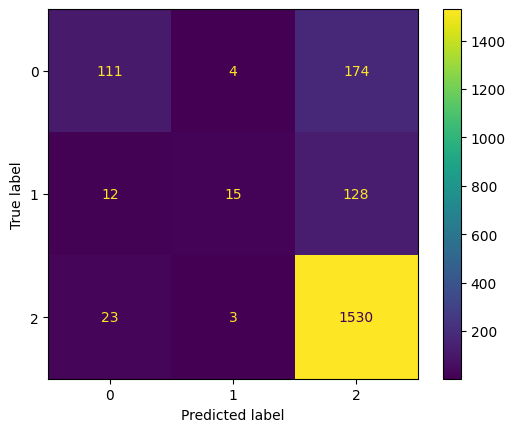


Tuning hyperparameters for Naive Bayes on Stemmed Reviews...
Best Parameters: {'alpha': 0.1}
Accuracy: 0.8060
              precision    recall  f1-score   support

           0       0.85      0.21      0.34       289
           1       0.50      0.01      0.01       155
           2       0.80      1.00      0.89      1556

    accuracy                           0.81      2000
   macro avg       0.72      0.41      0.42      2000
weighted avg       0.79      0.81      0.74      2000



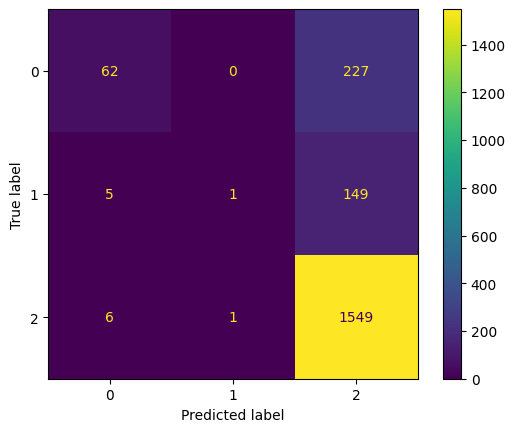


Tuning hyperparameters for SVM on Stemmed Reviews...
Best Parameters: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.8255
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       289
           1       0.57      0.03      0.05       155
           2       0.84      0.98      0.90      1556

    accuracy                           0.83      2000
   macro avg       0.71      0.48      0.49      2000
weighted avg       0.80      0.83      0.78      2000



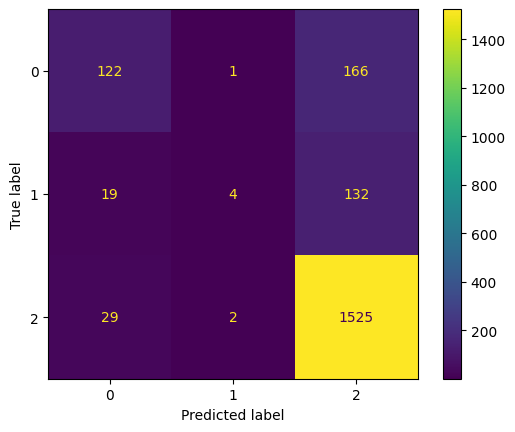


Tuning hyperparameters for Random Forest on Stemmed Reviews...
Best Parameters: {'max_depth': None, 'n_estimators': 300}
Accuracy: 0.8020
              precision    recall  f1-score   support

           0       0.76      0.21      0.33       289
           1       0.00      0.00      0.00       155
           2       0.80      0.99      0.89      1556

    accuracy                           0.80      2000
   macro avg       0.52      0.40      0.40      2000
weighted avg       0.74      0.80      0.74      2000



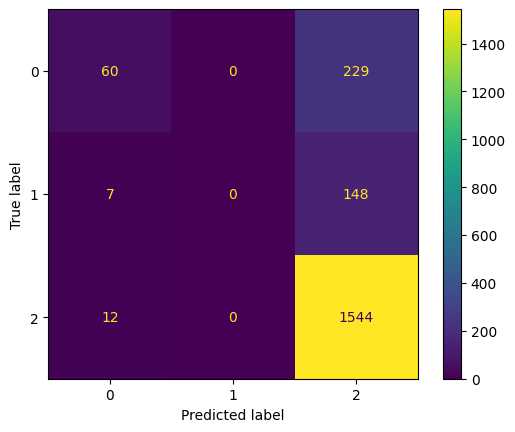

In [16]:
# Train and tune on Stemmed 
for name, model in models.items():
    warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")
    print(f"\nTuning hyperparameters for {name} on Stemmed Reviews...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_stem_tfidf, y_train_stem)
    best_model = grid_search.best_estimator_
    y_pred_stem = best_model.predict(X_test_stem_tfidf)
    accuracy = accuracy_score(y_test_stem, y_pred_stem) # get the accuracy score
    model_results_stemmed[name] = {
        "Accuracy": accuracy,
        "Best Params": grid_search.best_params_
    }
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_stem, y_pred_stem))
    cm = confusion_matrix(y_test_stem, y_pred_stem)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.show()
    print("=" * 50)



Tuning hyperparameters for Logistic Regression on Lemmatized Reviews...
Best Parameters: {'C': 1, 'max_iter': 100}
Accuracy: 0.8270
              precision    recall  f1-score   support

           0       0.76      0.38      0.50       289
           1       0.55      0.08      0.14       155
           2       0.84      0.99      0.90      1556

    accuracy                           0.83      2000
   macro avg       0.71      0.48      0.51      2000
weighted avg       0.80      0.83      0.79      2000



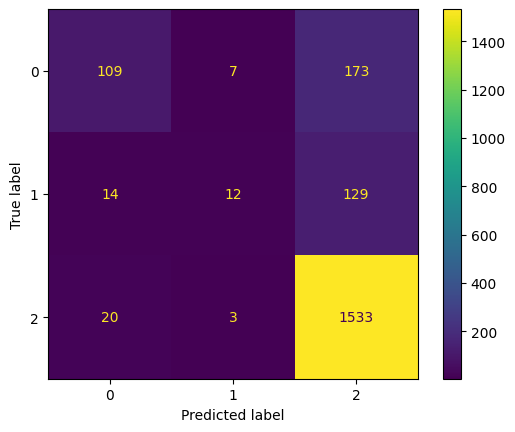


Tuning hyperparameters for Naive Bayes on Lemmatized Reviews...
Best Parameters: {'alpha': 0.1}
Accuracy: 0.8040
              precision    recall  f1-score   support

           0       0.87      0.20      0.33       289
           1       0.33      0.01      0.01       155
           2       0.80      0.99      0.89      1556

    accuracy                           0.80      2000
   macro avg       0.67      0.40      0.41      2000
weighted avg       0.78      0.80      0.74      2000



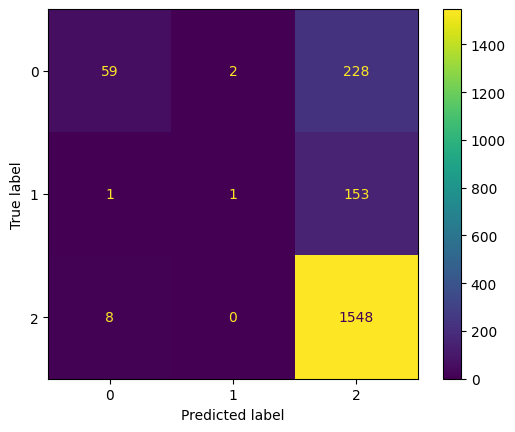


Tuning hyperparameters for SVM on Lemmatized Reviews...
Best Parameters: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.8275
              precision    recall  f1-score   support

           0       0.72      0.43      0.53       289
           1       0.60      0.04      0.07       155
           2       0.84      0.98      0.90      1556

    accuracy                           0.83      2000
   macro avg       0.72      0.48      0.50      2000
weighted avg       0.80      0.83      0.79      2000



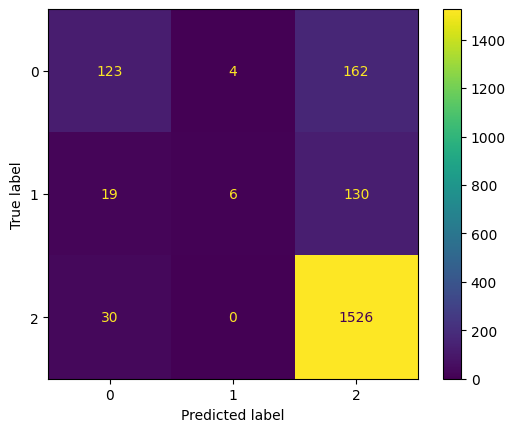


Tuning hyperparameters for Random Forest on Lemmatized Reviews...
Best Parameters: {'max_depth': None, 'n_estimators': 300}
Accuracy: 0.8050
              precision    recall  f1-score   support

           0       0.78      0.23      0.36       289
           1       1.00      0.01      0.01       155
           2       0.81      0.99      0.89      1556

    accuracy                           0.81      2000
   macro avg       0.86      0.41      0.42      2000
weighted avg       0.82      0.81      0.74      2000



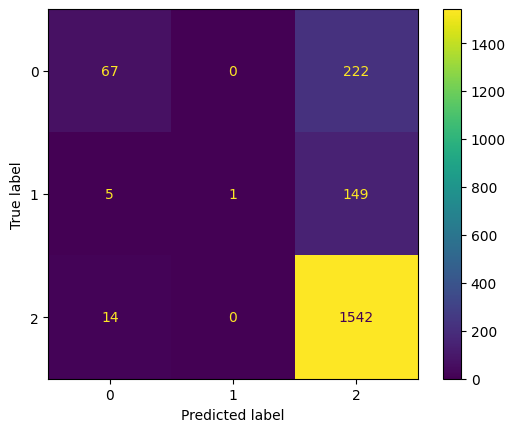

In [17]:
# Train and tune on Lemmatized 
for name, model in models.items():
    warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")
    print(f"\nTuning hyperparameters for {name} on Lemmatized Reviews...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_lem_tfidf, y_train_lem)
    best_model = grid_search.best_estimator_
    y_pred_lem = best_model.predict(X_test_lem_tfidf)
    accuracy = accuracy_score(y_test_lem, y_pred_lem) # get the accuracy score
    model_results_lemmatized[name] = {
        "Accuracy": accuracy,
        "Best Params": grid_search.best_params_
    }
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_lem, y_pred_lem))
    cm = confusion_matrix(y_test_lem, y_pred_lem)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.show()
    print("=" * 50)


# Evaluating Model Effectiveness: Stemmed vs. Lemmatized Text Processing

In [18]:
# Convert results to DataFrame
stemmed_df = pd.DataFrame(model_results_stemmed).T
lemmatized_df = pd.DataFrame(model_results_lemmatized).T

# Format accuracy for neat display
stemmed_df["Accuracy"] = stemmed_df["Accuracy"].apply(lambda x: f"{x:.4f}")
lemmatized_df["Accuracy"] = lemmatized_df["Accuracy"].apply(lambda x: f"{x:.4f}")

# Merge for comparison
comparison_df = pd.concat([
    stemmed_df.add_prefix("Stemmed "),
    lemmatized_df.add_prefix("Lemmatized ")
], axis=1)

# Show results
print("\nModel Performance Comparison")
comparison_df



Model Performance Comparison


,Stemmed Accuracy,Stemmed Best Params,Lemmatized Accuracy,Lemmatized Best Params
Logistic Regression,0.8280,"{'C': 1, 'max_iter': 100}",0.8270,"{'C': 1, 'max_iter': 100}"
Naive Bayes,0.8060,{'alpha': 0.1},0.8040,{'alpha': 0.1}
SVM,0.8255,"{'C': 1, 'kernel': 'linear'}",0.8275,"{'C': 1, 'kernel': 'linear'}"
Random Forest,0.8020,"{'max_depth': None, 'n_estimators': 300}",0.8050,"{'max_depth': None, 'n_estimators': 300}"


# Saving Model Artifacts for Deployment

In [49]:
import pickle

best_model = SVC(C = 1, kernel='linear')
best_model.fit(X_train_lem_tfidf, y_train_lem)

# Assuming `best_model` is your trained model and `tfidf_vectorizer` is your vectorizer
pickle.dump(best_model, open("./Models/sentiment_model.pkl", "wb"))
with open("./Models/tfidf_vectorizer_lem.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer_lem, f)